# Ch12-3 빈발 시계열 패턴 탐색

## 시계열 데이터란
각 요소가 시간과 값으로 구성된 데이터로, 반드시 순서 및 시간을 고려해야 하는 데이터이다.

### 시계열 데이터와 시퀀스 데이터의 차이

구분하지 않고 칭하기도 하지만, 시계열 데이터의 인덱스는 시간이라고 하고, 시퀀스 데이터의 인덱스는 순서라고 한다. 보통 시퀀스 데이터가 시계열 데이터에 포함되는 것이다. 그러나 일반적으로는 값이 연속형이고 인덱스가 시간인 경우를 시계열 데이터라고 부르고, 값이 주로 범주형이고 인덱스가 순서인 경우를 시퀀스 데이터라고 부른다. 

엄밀히 말해서 시계열 데이터도 시퀀스 데이터에 속함.(위에서 말하는거랑 다르잖아용)  

### 시계열 패턴의 정의

시계열의 패턴은 크게 **모양, 변화**에 의한 패턴과 **값**에 의한 패턴으로 구분할 수 있다.  
- 모양 패턴: 반복되는 모양  
- 변화 패턴: 증-감-증-감 ...  
- 값 패턴: 보통-큼-보통-매우작음-보통 ...  

문제: 계절성 혹은 주기성이 있는 시계열 데이터를 제외하면, 모양 패턴을 찾는 것은 거의 불가능에 가깝다.

### SAX: 시계열  -> 시퀀스 
시계열 데이터의 값은 연속형이기 때문에 패턴을 찾기가 매우 어렵다. 그렇기 때문에 시퀀스 데이터로 변환하는 작업을 하기도한다. 이렇게 시계열 데이터에서 패턴을 찾으려면 **이산화**가 필요하다.  

- SAX(symbolic aggregate approximation)이라는 방법을 사용하면 시계열 데이터를 효과적으로 이산화할 수 있다.  
단계는 이렇게 구성된다.  
    1. 윈도우 분할: 사용자가 설정    
    2. 윈도우별 대표값 계산: 값의 범위를 대표값 계산(평균 뿐 아니라 필요하다면 표준편차나 최대값 등등 사용할 수 있다.)  
    3. 알파벳 시퀀스로 변환: 대표값을 기준으로 알파벳 시퀀스로 변환

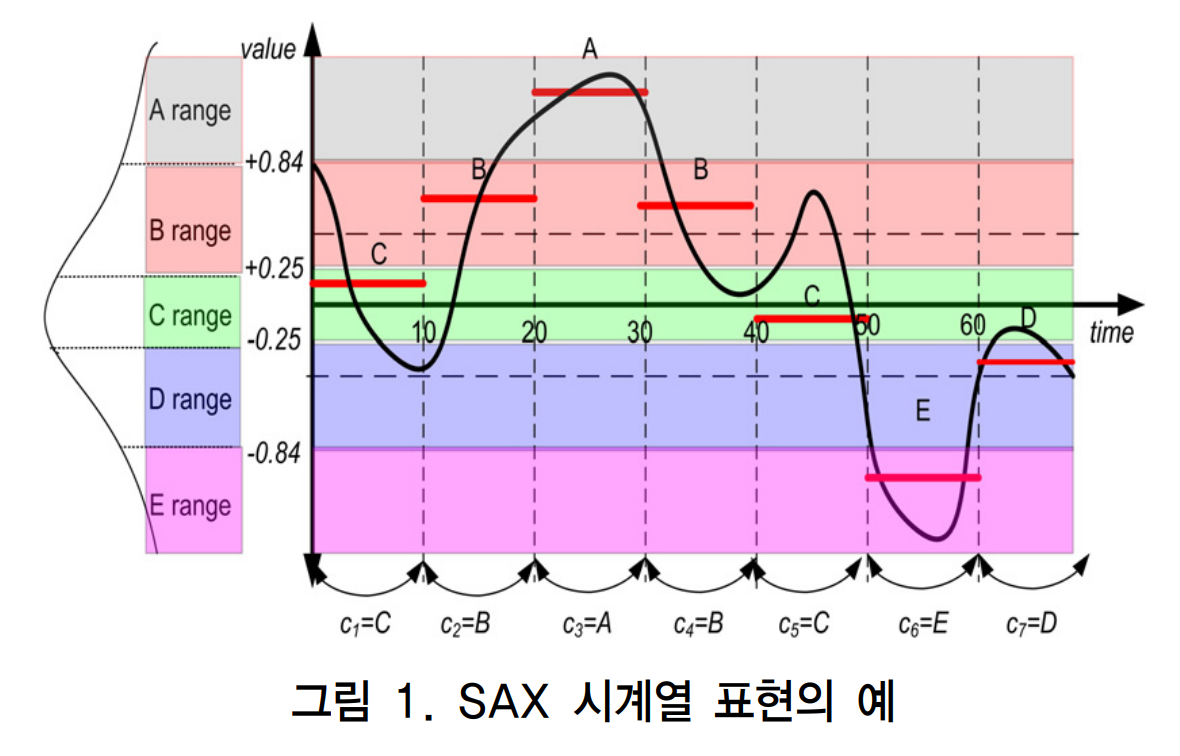
*(출처 : https://koreascience.kr/article/JAKO201029235191756.pdf)*

# SAX computation 실습

## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir(r"/Users/Angela/Desktop/과속대학쿠쿠루/2. 탐색적 데이터 분석/데이터")

print(pd.__version__)
print(np.__version__)

1.4.1
1.22.4


In [3]:
# 날짜 데이터의 포맷을 그대로 유지하며 불러오기
df = pd.read_excel("2018-20_코스피지수.xlsx", parse_dates = True) 
df.head()

,날짜,종가
0,2020-07-17,2201.19
1,2020-07-16,2183.76
2,2020-07-15,2201.88
3,2020-07-14,2183.61
4,2020-07-13,2186.06


하나의 시간에 여러 변수(값)가 있는 경우도 있다. 그런 시계열 데이터를 다변량 시계열이라고 한다. 위의 시계열 데이터는 단변량 시계열이다.  

### 시간에 따른 정렬
시간은 순서가 중요하기 때문에 습관적으로 정렬을 해주기로 한다.

In [4]:
df.sort_values(by = ['날짜'], inplace = True) 

## SAX 적용

### 윈도우 분할
입력은 세 개를 받는 `segmentation`함수를 만든다.  
```
    x = 시계열 데이터  
    w = 윈도우 사이즈  
    a = 알파벳 사이즈(숫자로, 숫자 만큼 알파벳 개수를 만듬)  
```
평균을 사용하는 SAX를 사용하기로 한다.

```
x[:w*int(len(x)/w)] : 시계열 데이터 x에 대하여 0번째 값부터 w로 나누는데, 나누어 떨어지는 값까지 보기위해 나누고 int로 바꾸었다. 그리고 w로 곱했기 때문에 나누어 떨어지는 값까지만 가져오기로 한다. 나머지는 따로 처리해야 할 것이다.  
reshape(w, -1) : 정상적으로 들어가는 윈도우까지만 처리하기로 하고, reshape로 행이 w개, 열이 -1(w의 값에 따라 계속 변동이 생길 것이기 때문에 자동으로 설정되도록, 알아서 적당한 값이 들어가도록 하는 -1로 설정한다.)로 바꾼다. 
행단위의 연산이고, 결과는 열처럼 나오기 때문에 axis = 1로 잡았다.

그리고 x를 윈도우 크기로 나누고 나머지, 남은 부분들은 그의 평균으로, hstack 을 이용하여위에 만든 window_mean에 행을 하나 추가하도록 한다. 
```

In [5]:
def segmentation(x, w, a): 
    # x: time series sample, w: window size, a: alphabet size
    window_mean = x[:w*int(len(x)/w)].reshape(w, -1).mean(axis = 1)
    if len(x) % w != 0:    
        window_mean = np.hstack([window_mean, x[w*int(len(x)/w):].mean()]) 
        # 남겨진 부분은 그 부분만 평균해서 window_mean에 추가
    
    return window_mean

### 대표값을 기반으로 break point(범위)나누기

break_points : 각 구간을 나누는 기준 값

```
구간의 범위를 설정해줄 수 있는 a.
wv : segmentation 함수의 결과물이 들어가게 되는 것.
a의 개수만큼 돌면서, 1/a, 2/a 3/a 만큼 백분위값을 돌면서 분할을 알파벳 크기만큼 하도록 한다. 
```

In [6]:
def find_break_points(wmv, a):       # wmv:  window mean vector
    break_points = [np.quantile(wmv, (i+1)/a) for i in range(a)]
    return break_points

### 알파벳 시퀀스 입력

각 윈도우 mean벡터를 알파벳으로 바꾸어주는 함수
```
65로 정의한 이유는 아스키코드를 사용하기 위함이며, 대문자 A를 의미한다. 
돌고있는 평균이 bp보다 작다면 현재 있는 알파벳을 넣도록 한다. break를 사용해 하나의 알파벳만 대응되도록 빠져나오며, 걸리기 않는다면 알파벳이 하나 증가하면서 돈다. 
```

In [7]:
def conversion_window(wv, break_points): # wv: window mean vector 
    alphabet_sequence = []
    for e in wv:
        alphabet = 65
        for bp in break_points:
            if e < bp:
                alphabet_sequence.append(chr(alphabet))
                break
            else:
                alphabet += 1   
                
    return alphabet_sequence

## 실습

### SAX 시계열 데이터 만들기

먼저 시계열 데이터를 윈도우 크기로 나눔

In [8]:
KOSPI = df['종가'].values
window_mean_vector = segmentation(x = KOSPI, w = 100, a = 5)

In [9]:
window_mean_vector

array([2282.725     , 2284.32      , 2291.51      , 2293.9475    ,
       2273.465     , 2251.4475    , 2287.11      , 2310.595     ,
       2300.5325    , 2284.09      , 2304.1175    , 2331.6275    ,
       2316.5025    , 2219.9075    , 2154.9       , 2143.095     ,
       2046.02      , 2041.21      , 2084.465     , 2076.4525    ,
       2090.9       , 2071.75      , 2104.65      , 2104.07      ,
       2066.2725    , 2074.5325    , 2063.865     , 2026.8725    ,
       2016.58      , 2067.02      , 2108.655     , 2128.7975    ,
       2186.1475    , 2197.195     , 2199.6325    , 2210.5925    ,
       2229.58      , 2200.03      , 2154.2325    , 2159.345     ,
       2179.7725    , 2156.5575    , 2153.5575    , 2207.5025    ,
       2223.96      , 2237.7925    , 2213.585     , 2197.4575    ,
       2188.5175    , 2092.725     , 2067.995     , 2057.7525    ,
       2038.79      , 2061.4175    , 2098.095     , 2097.        ,
       2127.005     , 2127.1075    , 2114.1275    , 2071.3925 

 break point 찾기 : 해당 값으로 구간이 나뉘도록 함

In [10]:
bps = find_break_points(window_mean_vector, 5)
bps

[2064.98, 2090.9, 2154.2325, 2216.0199999999995, 2331.6275]

 알파벳 시퀀스 입력: 각 윈도우가 어느 알파벳 범주에 속하는지 변환

In [12]:
alphabet_sequence = conversion_window(window_mean_vector, bps)
print(alphabet_sequence)

['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'D', 'C', 'A', 'A', 'B', 'B', 'C', 'B', 'C', 'C', 'B', 'B', 'A', 'A', 'A', 'B', 'C', 'C', 'D', 'D', 'D', 'D', 'E', 'D', 'D', 'D', 'D', 'D', 'C', 'D', 'E', 'E', 'D', 'D', 'D', 'C', 'B', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'C', 'D', 'D', 'D', 'D', 'E', 'E', 'D', 'C', 'E', 'E', 'D', 'B', 'A', 'A']


### 패턴 찾기